In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

from graphnet.models.data_representation.graphs.nodes.nodes import NodesAsPulses


/home/kbas/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


graphnet [MainProcess] WARNING  2025-12-09 14:34:19 - <module> - `jammy_flows` not available. Normalizing Flow functionality is missing.


In [2]:
# -------------------------------------------------
# 1) Dosyaları oku
# -------------------------------------------------
pulses_path = "/project/def-nahee/kbas/pone_parquet/pulses_batch_3240.parquet"
truth_path  = "/project/def-nahee/kbas/pone_parquet/truth_batch_3240.parquet"

pulses = pd.read_parquet(pulses_path)
truth  = pd.read_parquet(truth_path)

# Node feature olarak kullanacağımız kolonlar
feature_cols = ["om_x", "om_y", "om_z", "time", "charge"]

# Event'i tanımlayan ID kolonları
group_cols = ["run_id", "sub_run_id", "event_id", "sub_event_id"]

# Node tanımı: her pulse = 1 node
node_def = NodesAsPulses(
    input_feature_names=feature_cols,
)

# -------------------------------------------------
# 2) torch-cluster olmadan basit kNN edge fonksiyonu
# -------------------------------------------------
def build_knn_edges(coords: torch.Tensor, k: int) -> torch.Tensor:
    """
    coords: [N, 3] (om_x, om_y, om_z)
    k: her node için kaç komşu
    return: edge_index [2, E]
    """
    N = coords.size(0)

    if N == 0:
        return torch.empty((2, 0), dtype=torch.long)

    if N == 1:
        # tek node varsa self-loop koy
        idx = torch.arange(1, dtype=torch.long)
        return torch.stack([idx, idx], dim=0)

    # Çiftler arası uzaklık matrisi [N, N]
    dist = torch.cdist(coords, coords)

    # Her node için en yakın k komşu (kendisi hariç)
    k_neigh = min(k, N - 1)
    knn = dist.topk(k_neigh + 1, largest=False).indices[:, 1:]  # [N, k_neigh]

    src = torch.arange(N, dtype=torch.long).repeat_interleave(k_neigh)  # [N*k]
    tgt = knn.reshape(-1)                                               # [N*k]

    edge_index = torch.stack([src, tgt], dim=0)  # [2, E]

    # İstersen simetrik yap
    edge_index = to_undirected(edge_index, num_nodes=N)

    return edge_index


# -------------------------------------------------
# 3) Her event için ayrı bir graph oluştur
# -------------------------------------------------
graphs = []
k = 16  # kNN için komşu sayısı

for event_id, df_evt in pulses.groupby(group_cols):
    # -------- node features --------
    x_np = df_evt[feature_cols].to_numpy()
    x = torch.tensor(x_np, dtype=torch.float32)          # [num_pulses, 5]

    x = node_def(x)                                     # NodesAsPulses: aynen bırakıyor
    data = Data(x=x)

    # -------- edge'ler (geom üzerinden kNN) --------
    coords = x[:, :3]                                   # om_x, om_y, om_z
    data.edge_index = build_knn_edges(coords, k=k)

    # -------- label eşle --------
    run, sub_run, evt, sub_evt = event_id

    mask = (
        (truth["run_id"] == run) &
        (truth["sub_run_id"] == sub_run) &
        (truth["event_id"] == evt) &
        (truth["sub_event_id"] == sub_evt)
    )
    row = truth.loc[mask].iloc[0]

    # örnek: sadece totalEnergy'yi label yapalım
    y = torch.tensor([row["totalEnergy"]], dtype=torch.float32)
    data.y = y

    graphs.append(data)

# -------------------------------------------------
# 4) Küçük sanity check
# -------------------------------------------------
print(f"Oluşturulan event graph sayısı: {len(graphs)}")

if len(graphs) > 0:
    g0 = graphs[0]
    print(g0)
    print("x shape       :", g0.x.shape)          # [num_pulses, 5]
    print("edge_index shape:", g0.edge_index.shape)
    print("y             :", g0.y)


graphnet [MainProcess] INFO     2025-12-09 14:34:20 - NodesAsPulses.__init__ - Writing log to logs/graphnet_20251209-143420.log
Oluşturulan event graph sayısı: 34
Data(x=[4485, 5], edge_index=[2, 84105], y=[1])
x shape       : torch.Size([4485, 5])
edge_index shape: torch.Size([2, 84105])
y             : tensor([270.6545])


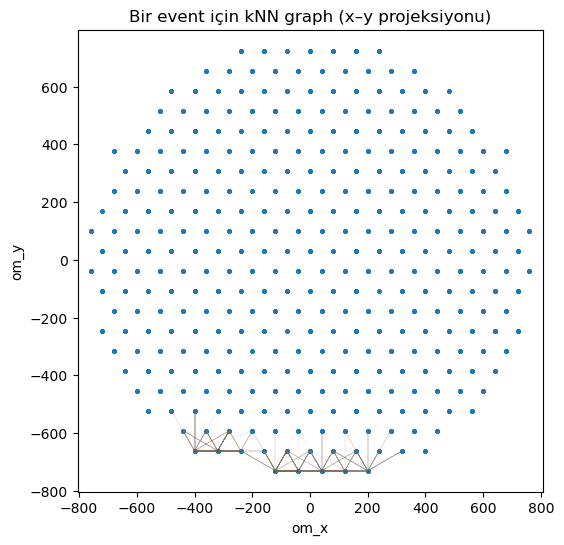

In [3]:
import matplotlib.pyplot as plt
import numpy as np

g = graphs[0]  # veya istediğin event indexi

coords = g.x[:, :3].cpu().numpy()          # [N, 3] → om_x, om_y, om_z
edge_index = g.edge_index.cpu().numpy()    # [2, E]

x = coords[:, 0]
y = coords[:, 1]

plt.figure(figsize=(6, 6))

# node'lar (pulse'lar) – sadece noktalar
plt.scatter(x, y, s=5, alpha=0.7)

# çok edge varsa grafik çamur olmasın diye ilk birkaç bin edge'i çizelim
max_edges = 2000
E = edge_index.shape[1]
use_E = min(E, max_edges)

for i in range(use_E):
    src = edge_index[0, i]
    tgt = edge_index[1, i]
    plt.plot(
        [x[src], x[tgt]],
        [y[src], y[tgt]],
        linewidth=0.3,
        alpha=0.1,
    )

plt.xlabel("om_x")
plt.ylabel("om_y")
plt.title("Bir event için kNN graph (x–y projeksiyonu)")
plt.axis("equal")
plt.show()


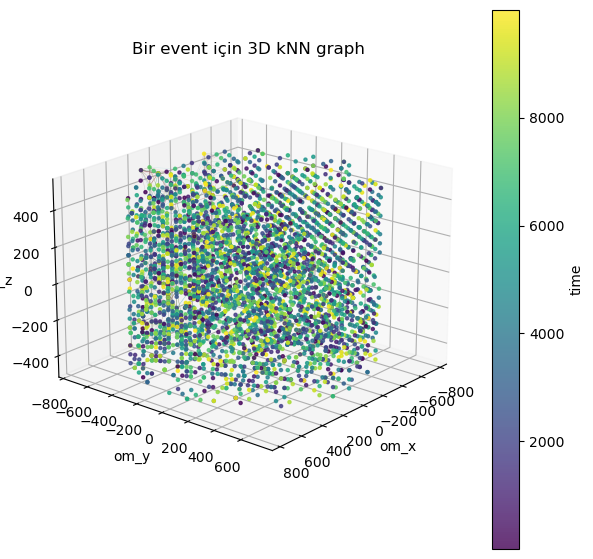

In [4]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np

g = graphs[0]   # hangi event'i görmek istiyorsan

coords = g.x[:, :3].cpu().numpy()
edge_index = g.edge_index.cpu().numpy()

x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
time = g.x[:, 3].cpu().numpy()   # renklendirme için time (istersen charge da olur)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(x, y, z, s=5, c=time, alpha=0.8)
fig.colorbar(sc, ax=ax, label="time")

max_edges = 2000
E = edge_index.shape[1]
use_E = min(E, max_edges)

for i in range(use_E):
    src = edge_index[0, i]
    tgt = edge_index[1, i]
    ax.plot(
        [x[src], x[tgt]],
        [y[src], y[tgt]],
        [z[src], z[tgt]],
        linewidth=0.3,
        alpha=0.15,
    )

ax.set_xlabel("om_x")
ax.set_ylabel("om_y")
ax.set_zlabel("om_z")
ax.set_title("Bir event için 3D kNN graph")

# farklı açıdan görmek istersen:
ax.view_init(elev=20, azim=40)  # değerlerle oynayabilirsin

plt.show()


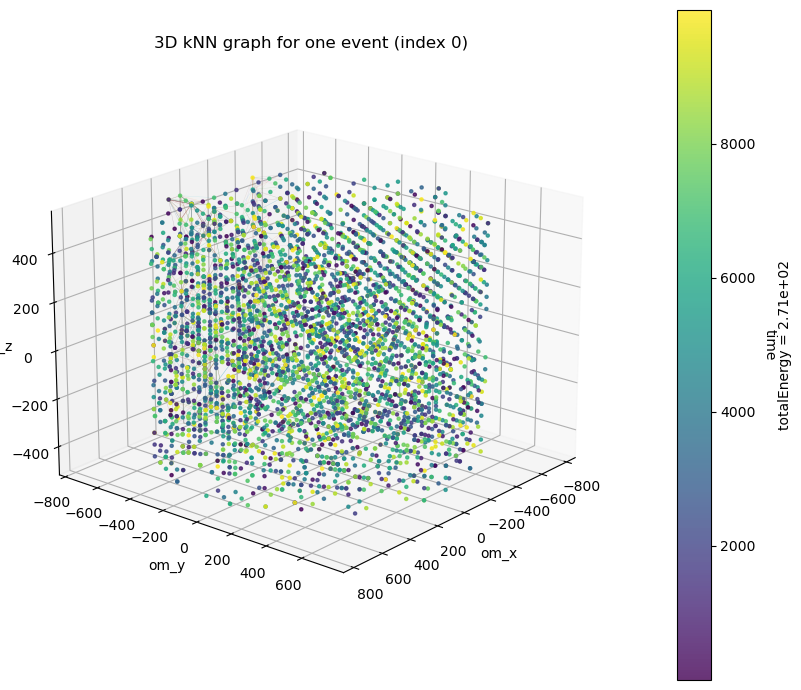

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np

# Pick one event graph
event_index = 0
g = graphs[event_index]

# Node positions and features
coords = g.x[:, :3].cpu().numpy()          # [N, 3] = (om_x, om_y, om_z)
edge_index = g.edge_index.cpu().numpy()    # [2, E]

x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
time = g.x[:, 3].cpu().numpy()             # use time as color
charge = g.x[:, 4].cpu().numpy()           # (optional, if you want it later)

# Event-level label (here: totalEnergy)
total_energy = float(g.y.item())  # assuming y is totalEnergy

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

# --- Nodes (pulses) ---
scatter = ax.scatter(
    x, y, z,
    s=5,
    c=time,       # color by time
    alpha=0.8,
)

cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("time", rotation=270, labelpad=15)

# --- Edges (only a subset, to avoid clutter) ---
max_edges = 2000
E = edge_index.shape[1]
use_E = min(E, max_edges)

for i in range(use_E):
    src = edge_index[0, i]
    tgt = edge_index[1, i]
    ax.plot(
        [x[src], x[tgt]],
        [y[src], y[tgt]],
        [z[src], z[tgt]],
        linewidth=0.3,
        alpha=0.15,
    )

# --- Axes and title ---
ax.set_xlabel("om_x")
ax.set_ylabel("om_y")
ax.set_zlabel("om_z")
ax.set_title(f"3D kNN graph for one event (index {event_index})")

# Choose a nice viewing angle
ax.view_init(elev=20, azim=40)

# --- Event label on the right side of the figure ---
fig.text(
    0.98, 0.5,
    f"totalEnergy = {total_energy:.2e}",
    ha="right",
    va="center",
    rotation=90,
)

plt.tight_layout()
plt.show()


In [9]:
for event_id, df_evt in pulses.groupby(group_cols):
    ...
    row = truth.loc[mask].iloc[0]

    # old:
    # y = torch.tensor([row["totalEnergy"]], dtype=torch.float32)
    # data.y = y

    # new: keep totalEnergy in y, but also store extra metadata
    data.y = torch.tensor([row["totalEnergy"]], dtype=torch.float32)

    # extra labels as attributes on the graph
    data.zenith  = float(row["zenith"])
    data.azimuth = float(row["azimuth"])
    data.vertex  = torch.tensor(
        [row["x"], row["y"], row["z"]],
        dtype=torch.float32,
    )
    data.initial_type = int(row["initialType"])
    data.final_type1  = int(row["finalType1"])
    data.final_type2  = int(row["finalType2"])

    graphs.append(data)


In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np

# pick one event
event_index = 0
g = graphs[event_index]

coords = g.x[:, :3].cpu().numpy()          # [N, 3] = (om_x, om_y, om_z)
edge_index = g.edge_index.cpu().numpy()    # [2, E]

x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
time   = g.x[:, 3].cpu().numpy()           # time for coloring
charge = g.x[:, 4].cpu().numpy()

# event-level labels
total_energy = float(g.y.item())
zenith  = float(g.zenith)
azimuth = float(g.azimuth)
vx, vy, vz = g.vertex.cpu().numpy().tolist()
initial_type = g.initial_type
final_type1  = g.final_type1
final_type2  = g.final_type2

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

# --- nodes (pulses) ---
scatter = ax.scatter(
    x, y, z,
    s=5,
    c=time,       # color by time
    alpha=0.8,
)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("time", rotation=270, labelpad=15)

# --- edges (subset to avoid clutter) ---
max_edges = 2000
E = edge_index.shape[1]
use_E = min(E, max_edges)

for i in range(use_E):
    src = edge_index[0, i]
    tgt = edge_index[1, i]
    ax.plot(
        [x[src], x[tgt]],
        [y[src], y[tgt]],
        [z[src], z[tgt]],
        linewidth=0.3,
        alpha=0.15,
    )

# --- true vertex (interaction point) ---
ax.scatter(
    [vx], [vy], [vz],
    s=60,
    marker="x",
    color="red",
    label="true vertex",
)

# --- true direction vector (from zenith, azimuth) ---
# convert (zenith, azimuth) to a unit direction vector
dx = np.sin(zenith) * np.cos(azimuth)
dy = np.sin(zenith) * np.sin(azimuth)
dz = np.cos(zenith)

# scale the arrow to make it visible in the detector
L = 300.0
ax.quiver(
    vx, vy, vz,
    dx * L, dy * L, dz * L,
    color="red",
    linewidth=2.0,
    arrow_length_ratio=0.1,
    label="true direction",
)

# --- axes, title, legend ---
ax.set_xlabel("om_x")
ax.set_ylabel("om_y")
ax.set_zlabel("om_z")
ax.set_title(f"3D kNN graph for one event (index {event_index})")
ax.view_init(elev=20, azim=40)
ax.legend(loc="upper left")

# --- all labels on the right side ---
label_text = (
    f"totalEnergy = {total_energy:.2e}\n"
    f"zenith      = {zenith:.3f}\n"
    f"azimuth     = {azimuth:.3f}\n"
    f"vertex      = ({vx:.1f}, {vy:.1f}, {vz:.1f})\n"
    f"initialType = {initial_type}\n"
    f"finalType1  = {final_type1}\n"
    f"finalType2  = {final_type2}"
)

fig.text(
    0.98, 0.5,
    label_text,
    ha="right",
    va="center",
    fontsize=9,
)

plt.tight_layout()
plt.show()


AttributeError: 'GlobalStorage' object has no attribute 'zenith'

In [11]:
print(truth.columns.tolist())
truth.head(3).T


['run_id', 'sub_run_id', 'event_id', 'sub_event_id', 'zenith', 'azimuth', 'x', 'y', 'z', 'initialType', 'finalType1', 'finalType2', 'totalEnergy', 'batch_id']


,0,1,2
run_id,3.240000e+03,3.240000e+03,3.240000e+03
sub_run_id,4.294967e+09,4.294967e+09,4.294967e+09
event_id,1.600000e+01,3.400000e+01,3.500000e+01
sub_event_id,0.000000e+00,0.000000e+00,0.000000e+00
zenith,1.997631e+00,1.683089e+00,2.314079e+00
azimuth,4.651655e-02,5.368651e+00,1.203806e+00
x,1.011859e+03,6.727675e+02,-3.782339e+02
y,-1.936026e+02,-1.522213e+02,6.278384e+02
z,-3.739214e+01,-4.568366e+02,-9.463981e+01
initialType,1.400000e+01,1.400000e+01,1.400000e+01


In [5]:
# pip install --user ipympl
# pip install ipympl

In [8]:
import plotly.graph_objects as go
import numpy as np
# have an interactive plot

ModuleNotFoundError: No module named 'plotly'

In [ ]:
g = graphs[0]
coords = g.x[:, :3].cpu().numpy()
edge_index = g.edge_index.cpu().numpy()

x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
time = g.x[:, 3].cpu().numpy()

node_trace = go.Scatter3d(
    x=x, y=y, z=z,
    mode="markers",
    marker=dict(
        size=3,
        color=time,
        colorscale="Viridis",
        opacity=0.8,
        colorbar=dict(title="time"),
    ),
)

max_edges = 2000
E = edge_index.shape[1]
use_E = min(E, max_edges)

xe, ye, ze = [], [], []
for i in range(use_E):
    s = edge_index[0, i]
    t = edge_index[1, i]
    xe += [x[s], x[t], None]
    ye += [y[s], y[t], None]
    ze += [z[s], z[t], None]

edge_trace = go.Scatter3d(
    x=xe, y=ye, z=ze,
    mode="lines",
    line=dict(width=1),
    opacity=0.2,
    showlegend=False,
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    scene=dict(
        xaxis_title="om_x",
        yaxis_title="om_y",
        zaxis_title="om_z",
    ),
    title="Bir event için 3D kNN graph",
)
fig.show()
